### Make sure some stuff are set up

1. Run `jupyter nbextension enable --py widgetsnbextension` to enable widgets

2. Install graphviz through ``brew`` or ``apt-get``

3. Install graphviz's Python binding:

    import sys
    !{sys.executable} -m pip install graphviz

### Import dependencies

In [4]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor, export_graphviz

from graphviz import Source

from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive

import ipywidgets as widgets

### How does the data look like?

In [5]:
filename = 'communities.data'

df_raw_data = pd.read_csv(filename)
df_raw_data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [7]:
len(df_raw_data)

1994

### Let's select the features together?

In [9]:
target = 'ViolentCrimesPerPop'
protected = 'racepctblack'

params = {col : True for col in set(df_raw_data.columns)- set([target, protected, 'communityname'])}

In [10]:
df_cleaned = None


def clean_data(**params):
    global df_cleaned
    df_cleaned = df_raw_data.copy(deep=True) # Refresh raw data at every interaction
    
    dropped_cols = [k for k in params if not params[k]] # Features with unmarked check boxes
    
    df_cleaned.drop(dropped_cols + ['communityname'], inplace=True, axis=1) # Switching off features by dropping them
    df_cleaned = df_cleaned.replace({'?': np.nan}).dropna() # Greedy "drop N/A" (refer to the other notebook for )
    
    return df_cleaned


inter1=interactive(clean_data, **params)
display(inter1)

interactive(children=(Checkbox(value=True, description='PctEmploy'), Checkbox(value=True, description='PctImmi…

In [12]:
df_cleaned.head()

,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,PolicBudgPerPop,ViolentCrimesPerPop
16,36,1,1000,1,0.15,0.31,0.40,0.63,0.14,0.06,...,0.1,0.64,0.22,0.06,0.39,0.84,0.06,0.06,0.26,0.49
23,19,193,93926,1,0.11,0.43,0.04,0.89,0.09,0.06,...,0.02,0.86,0.29,0.16,0.12,0.07,0.04,0.01,0.09,0.63
33,51,680,47672,1,0.09,0.43,0.51,0.58,0.04,0.01,...,0.03,0.5,0.1,0.14,0.11,0.19,0.05,0.01,0.1,0.31
68,34,23,58200,1,0.05,0.59,0.23,0.39,0.09,1.00,...,0.04,0.79,0.31,0.01,0.73,0.28,0,0.02,0.23,0.50
74,9,9,46520,1,0.08,0.39,0.08,0.85,0.04,0.25,...,0.02,0.21,0.31,0.07,0.21,0.04,0.02,0.01,0.11,0.14


### Let's see how a Decision Tree looks like?

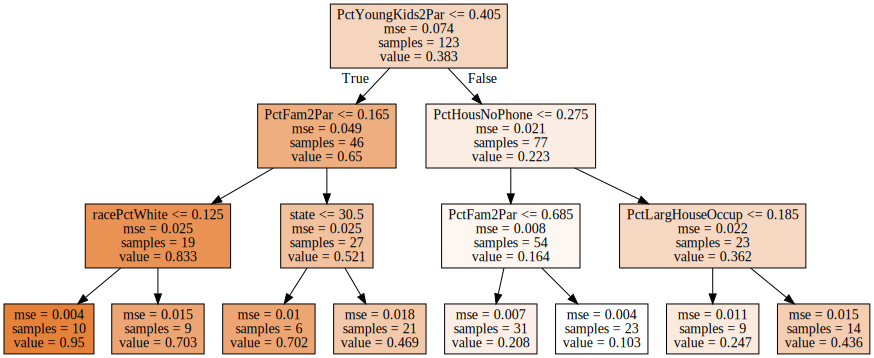

In [13]:
df_biased = df_cleaned.copy(deep=True)
    
# Vanilla ML
X = df_biased[df_biased.columns[:-1]]
Y = df_biased[target]
estimator = DecisionTreeRegressor(random_state=0, criterion='mse', splitter= 'best', max_depth=3)
estimator.fit(X, Y)
    
# Render Decision Tree
labels = X.columns
graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, filled = True))
display(SVG(graph.pipe(format='svg')))

### What happens if a phenomenon such as overpolicing with racial profiling skews the data?

In [14]:
ratio = 1.0
pct_black_median = None


# If a given row x (a training example) has 'racepctblack' greater than the median value, then
# multiply the outcome 'ViolentCrimesPerPop' by the user-defined ratio; otherwise, multiply by
# the inverse of the user-defined ratio.
# Interpretation: the greater the ratio, the worst is the bias against communities with above
# average Black populations; the smaller the ratio, the more favorable is the bias; setting to
# 1.0 keeps the data in its original form.

def apply_bias(x):
    global ratio, pct_black_median
    return x[target]*ratio if x[protected] > pct_black_median else x[target]*(1/ratio)


def plot_tree(overpolicing=False):
    global df_cleaned, ratio, pct_black_median # Made global to interface with function apply_bias
    ratio = 2.0 if overpolicing else 1.0 # Set the amount of bias depending on the overpolicing flag
    
    # Median also used in function apply_bias
    pct_black_median = df_cleaned[protected].median()
    
    df_biased = df_cleaned.copy(deep=True)
    df_biased[target] = df_biased.apply(apply_bias, axis=1)
    
    # Vanilla ML
    X = df_biased[df_biased.columns[:-1]]
    Y = df_biased[target]
    estimator = DecisionTreeRegressor(random_state=0, criterion='mse', splitter= 'best', max_depth=3)
    estimator.fit(X, Y)
    
    # Render Decision Tree
    labels = X.columns
    graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, filled = True))
    display(SVG(graph.pipe(format='svg')))
    return estimator


inter=interactive(plot_tree, overpolicing=False)
display(inter)

interactive(children=(Checkbox(value=False, description='overpolicing'), Output()), _dom_classes=('widget-inte…